In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as f 
import torch.optim as optim
from time import time
import numpy as np

In [3]:
dtype = torch.float32

# set constants
pi = torch.tensor(np.pi, dtype=dtype)

# Define exact solution
def fun_u(t,x):
    return torch.exp(-0.1*t*pi**2)*torch.cos(pi*x) #6*(x+1)*( (x+1)**3 - 24*t )/( (x+1)**3 + 12*t )**2

In [50]:
# Set number of data points
N_r = 10000
N_d = 500

# Set boundary
tmin = 0.
tmax = 1.0
xmin = -1.
xmax = 1.

# Device over which model has to be trained
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Lower bounds
lb = torch.tensor([tmin, xmin], dtype=dtype).to(device)
# Upper bounds
ub = torch.tensor([tmax, xmax], dtype=dtype).to(device)

# Set random seed for reproducible results
torch.manual_seed(0)

# Draw uniformly sampled collocation points
t_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True).to(device)*(ub[0]-lb[0]) + lb[0]
x_r = torch.rand((N_r,1), dtype=dtype, requires_grad=True).to(device)*(ub[1]-lb[1]) + lb[1]
X_r = torch.concat([t_r, x_r], axis=1)

# Draw uniformly sampled sample points
t_d = torch.rand((N_d,1), dtype=dtype).to(device)*(ub[0]-lb[0]) + lb[0]
x_d = torch.rand((N_d,1), dtype=dtype).to(device)*(ub[1]-lb[1]) + lb[1]
X_d = torch.concat([t_d, x_d], axis=1)

# Sampled data inside domain
u_data = fun_u(t_d,x_d)

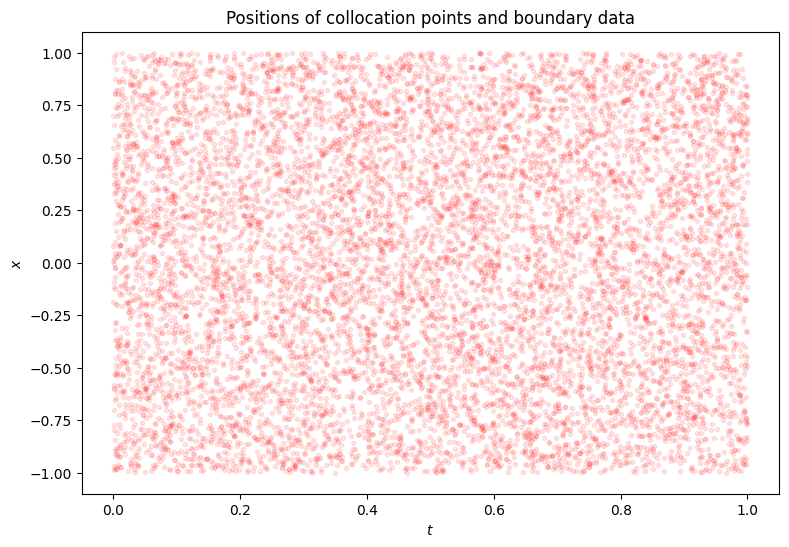

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_hidden_layers=12, num_neurons_per_layer=20):
        super(NeuralNetwork, self).__init__()

        # Model coefficients (Anything which needed to be discovered should be Parameter of the model, here it is cxx)
        self.ct = torch.tensor(1.0, requires_grad=False)
        self.cxx = nn.Parameter(torch.tensor(0.0, requires_grad=True))  # Diffusion coefficient
        self.cx = torch.tensor(0.0, requires_grad=False)
        self.c1 = torch.tensor(0.0, requires_grad=False)

        # Input layer (2D input: time + space)
        self.input_layer = nn.Linear(2, num_neurons_per_layer)
        
        # Append Hidden layers
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_neurons_per_layer, num_neurons_per_layer) 
            for _ in range(num_hidden_layers)
        ])
        
        # Output is 1D
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)
    
    def forward(self, x):
        x = f.selu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = f.selu(layer(x))
        x = self.output_layer(x)
        return x

In [51]:
def compute_loss(model, X_r, X_d, u_data):
    X_r = X_r.detach().requires_grad_(True)
    
    # Split t and x to compute partial derivatives
    t, x = X_r[:, 0:1], X_r[:,1:2]

    # Determine residual 
    u = model(torch.concat([t, x], axis=1))

    # Compute gradients
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),create_graph=True,allow_unused=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),create_graph=True,allow_unused=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u),create_graph=True,allow_unused=True)[0]
    
    # Get model coefficients
    ct = model.ct
    cxx = model.cxx
    cx = model.cx
    c1 = model.c1
    
    # Model discovery loss term
    loss = torch.mean(torch.square( ct*u_t + cxx*u_xx + cx*u_x + c1*u ))
    
    # Data loss term
    X_d = X_d.detach().requires_grad_(True)
    t_d, x_d = X_d[:, 0:1], X_d[:,1:2]
    u_d = model(torch.stack([t_d[:,0], x_d[:,0]], axis=1))
    loss += torch.mean(torch.square(u_d - u_data))
    
    # Coefficient regularization
    loss += 0.01*(torch.abs(cxx) + torch.abs(c1))
    
    return loss

In [ ]:
# Initialize model aka tilde u
model = NeuralNetwork().to(device)

# Learning rate
lr = 1e-3

# Choose the optimizer
optimizer = optim.Adam(model.parameters(),lr=lr)

# Number of training epochs
N = 3000
hist = []

In [ ]:
# Start timer
t0 = time()

for i in range(N+1):
    # Reset gradient of optimizer to 0
    optimizer.zero_grad()

    # Compute loss 
    loss = compute_loss(model, X_r, X_d, u_data)
    loss.backward()

    # Perform gradient descent step
    optimizer.step()

    # Append current loss to hist
    hist.append(loss.item())

    # Output current loss after 50 iterates
    if i % 50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss.item()))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 7.25815535e-01
It 00050: loss = 4.02190425e-02
It 00100: loss = 1.97938383e-02
It 00150: loss = 1.81987826e-02
It 00200: loss = 1.57157667e-02
It 00250: loss = 1.48822805e-02
It 00300: loss = 1.30320285e-02
It 00350: loss = 1.30346455e-02
It 00400: loss = 1.24408929e-02
It 00450: loss = 1.02662109e-02
It 00500: loss = 1.26035279e-02
It 00550: loss = 6.62324252e-03
It 00600: loss = 6.31321780e-03
It 00650: loss = 7.57988356e-03
It 00700: loss = 5.92331169e-03
It 00750: loss = 4.26002499e-03
It 00800: loss = 3.82771133e-03
It 00850: loss = 3.62262246e-03
It 00900: loss = 3.65652516e-03
It 00950: loss = 3.71927256e-03
It 01000: loss = 2.80246371e-03
It 01050: loss = 2.67065363e-03
It 01100: loss = 2.32707243e-03
It 01150: loss = 2.33169110e-03
It 01200: loss = 5.34272753e-03
It 01250: loss = 2.06554960e-03
It 01300: loss = 2.39819032e-03
It 01350: loss = 1.90957845e-03
It 01400: loss = 1.99838728e-03
It 01450: loss = 1.91101199e-03
It 01500: loss = 1.73772569e-03
It 01550

In [55]:
# Checking that the linear and diffusive coefficients 
#     combine to produce the correct model based on the training data

check = (-pi**2*model.cxx + model.c1)
print(check.detach().numpy()/(0.1*pi.numpy()**2)) # Exact value is 1 for a correct model

0.6710736976244442


Text(0.5, 0.92, 'Solution of diffusion equation')

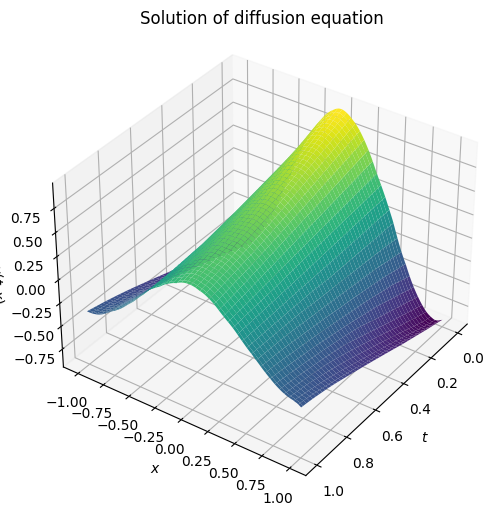

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 1000
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(torch.tensor(Xgrid,dtype=dtype))

# Reshape upred
U = upred.detach().numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(t,x)$')
ax.set_title('Solution of diffusion equation')